In [1]:
import os
import glob
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [2]:
# Constants
experiments_per_group = 4  # Number of experiments per group
workload_labels = ['IPA', 'FA2-low', 'FA2-high', 'RIM']

# Get list of log files
log_files = glob.glob('../../energy_logs/energy-video-mul-*.txt')

# Sort the log files numerically based on the experiment number in the filename
log_files.sort(key=lambda x: int(os.path.splitext(
    os.path.basename(x))[0].split('-')[-1]))

# Total number of experiments based on the number of log files
total_experiments = len(log_files)

# Calculate the number of groups needed
num_groups = math.ceil(total_experiments / experiments_per_group)

# Initialize groups based on the number of groups and experiments per group
groups = [
    [
        {'times': [], 'energy_pkg': [], 'energy_ram': []} for _ in range(experiments_per_group)
    ] for _ in range(num_groups)
]

In [3]:
# Process each log file
for idx, log_file in enumerate(log_files):
    # Map to workload label based on the file's position in the sorted list
    label = workload_labels[idx % len(workload_labels)]

    # Map to group and experiment indices
    group_index = idx // experiments_per_group
    experiment_index = idx % experiments_per_group

    # Print the mapping
    filename = os.path.basename(log_file)
    print(f"Mapping: {filename} -> {label}")

    # Dictionaries to hold energy readings indexed by time
    time_to_energy_pkg = {}
    time_to_energy_ram = {}

    # Open and read the log file
    with open(log_file, 'r') as file:
        for line in file:
            line = line.strip()
            # Skip empty lines and lines starting with '#'
            if not line or line.startswith('#'):
                continue
            # Split the line into parts
            parts = line.split()
            # Skip lines that do not have 4 parts
            if len(parts) != 4:
                continue
            time_str, value_str, unit, event = parts
            # Try to parse time and value
            try:
                time = float(time_str)
                value = float(value_str)
            except ValueError:
                continue  # Skip lines with invalid numbers
            # Store the energy readings indexed by time
            if event == 'power/energy-pkg/':
                time_to_energy_pkg[time] = value
            elif event == 'power/energy-ram/':
                time_to_energy_ram[time] = value

    # Now combine the readings at each timestamp
    times = sorted(set(time_to_energy_pkg.keys()) &
                   set(time_to_energy_ram.keys()))
    for time in times:
        energy_pkg = time_to_energy_pkg[time]
        energy_ram = time_to_energy_ram[time]
        # Convert time from seconds to minutes
        time_minutes = time / 60
        # Append to the experiment's lists within the group
        groups[group_index][experiment_index]['times'].append(time_minutes)
        groups[group_index][experiment_index]['energy_pkg'].append(energy_pkg)
        groups[group_index][experiment_index]['energy_ram'].append(energy_ram)

    # Store the label for plotting
    groups[group_index][experiment_index]['label'] = label

Mapping: energy-video-mul-1.txt -> IPA
Mapping: energy-video-mul-2.txt -> FA2-low
Mapping: energy-video-mul-3.txt -> FA2-high
Mapping: energy-video-mul-5.txt -> RIM
Mapping: energy-video-mul-6.txt -> IPA
Mapping: energy-video-mul-7.txt -> FA2-low
Mapping: energy-video-mul-8.txt -> FA2-high
Mapping: energy-video-mul-10.txt -> RIM
Mapping: energy-video-mul-11.txt -> IPA
Mapping: energy-video-mul-12.txt -> FA2-low
Mapping: energy-video-mul-13.txt -> FA2-high
Mapping: energy-video-mul-15.txt -> RIM
Mapping: energy-video-mul-16.txt -> IPA
Mapping: energy-video-mul-17.txt -> FA2-low
Mapping: energy-video-mul-18.txt -> FA2-high
Mapping: energy-video-mul-20.txt -> RIM


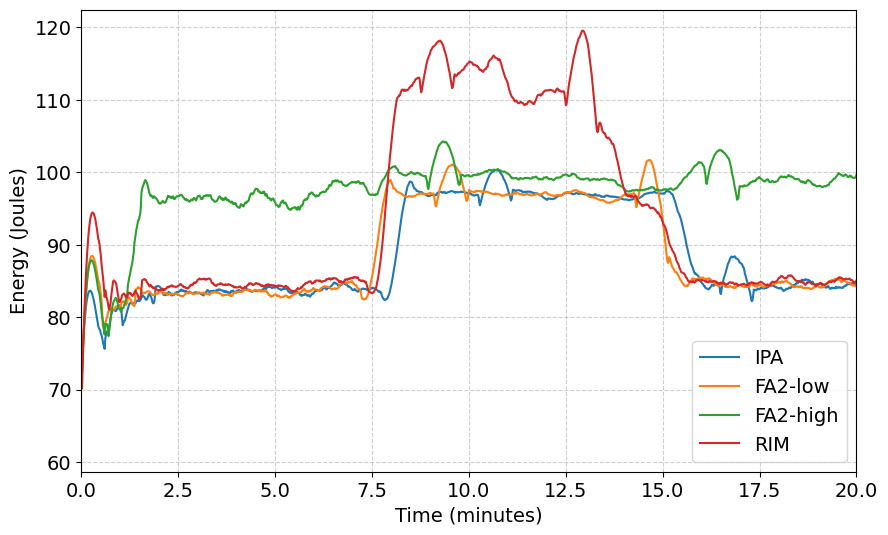

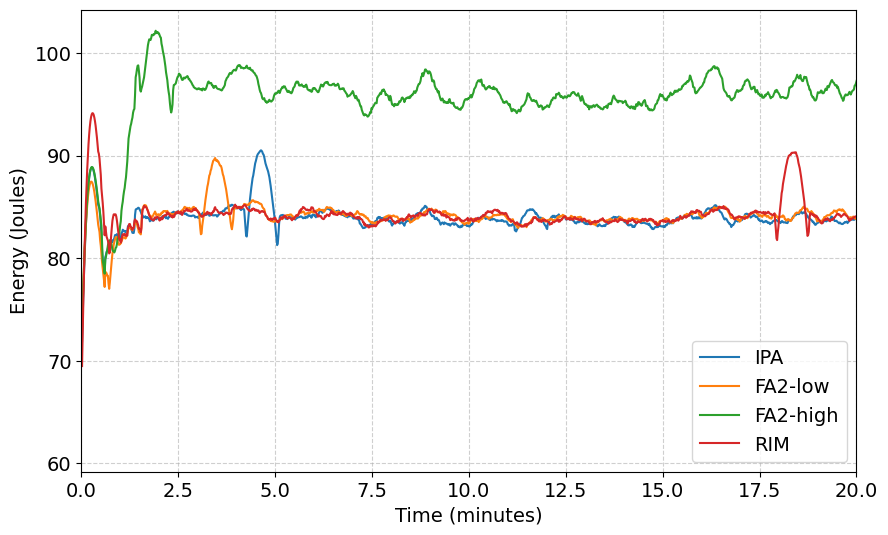

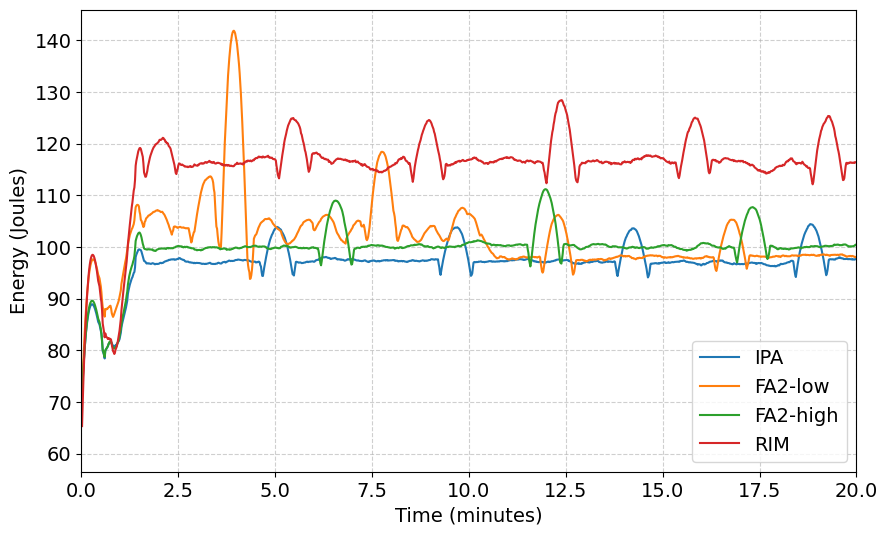

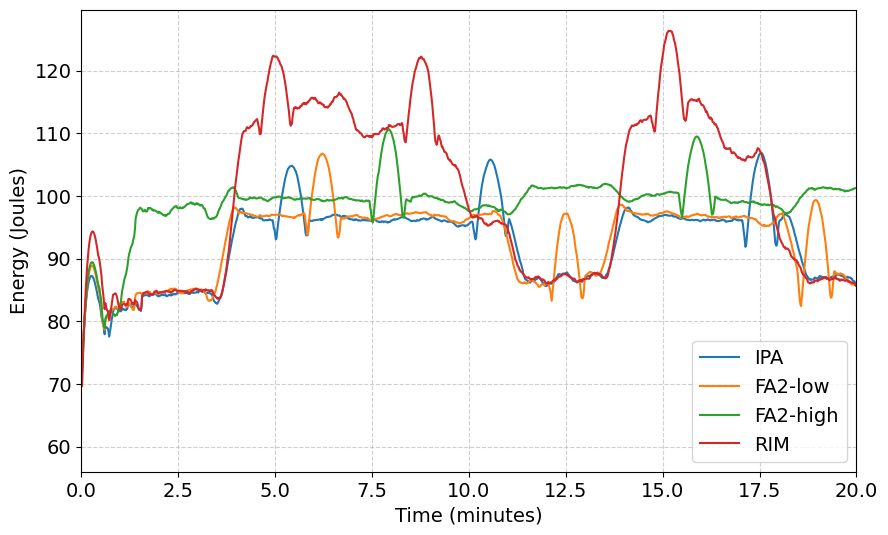

In [4]:
# Plotting the data for each group
output_dir = 'plots'
os.makedirs(output_dir, exist_ok=True)
for i, group in enumerate(groups):
    plt.figure(figsize=(10, 6))
    # Plot each experiment within the group
    for j, experiment in enumerate(group):
        times = experiment['times']
        energy_pkg = experiment['energy_pkg']
        label = experiment.get('label', f'Experiment {j+1}')
        if not times:
            continue  # Skip if no data
        # Determine window size for smoothing
        data_length = len(energy_pkg)
        # Ensure window_size is odd and less than or equal to data_length
        window_size = min(51, data_length - (1 - data_length % 2))
        poly_order = 3  # Polynomial order for the filter
        if data_length >= window_size and window_size > poly_order:
            energy_pkg_smoothed = savgol_filter(
                energy_pkg, window_size, poly_order)
        else:
            # If data is too short or window size is invalid, skip smoothing
            energy_pkg_smoothed = energy_pkg
        plt.plot(
            times,
            energy_pkg_smoothed,
            label=label
        )
    plt.xlabel('Time (minutes)', fontsize=14)
    plt.ylabel('Energy (Joules)', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(0, 20)  # Each experiment lasts 20 minutes
    plt.legend(loc='lower right', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    plt.savefig(f'plots/energy_plot_group_{i+1}.png',
                dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.close()
